# Import Libraries

In [30]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Data Collection

In [9]:
# Need to call out data import of either full data or filtered data
data = pd.read_csv(r"C:\Users\theni\Downloads\data\processed_data\aggregated_news.csv.gz")

C:\Users\theni\AppData\Local\Temp\ipykernel_15364\339421582.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\theni\Downloads\data\processed_data\aggregated_news.csv.gz")


,Date,Article_title,Stock_symbols
0,1914-09-16 00:00:00 UTC,1914. Празднование столетия М.Ю. Лермонтова от...,NaN
1,1914-09-16 00:00:00 UTC,1914. Русские войска вступили в пределы Венгрии,NaN
2,1914-09-17 00:00:00 UTC,1914. Das ist Nesteroff!,NaN
3,1914-09-17 00:00:00 UTC,1914. Бульдог-гонец под Льежем,NaN
4,1914-09-18 00:00:00 UTC,1914. Под Люблином пойман швабский зверь,NaN


In [11]:
data.tail()

,Date,Article_title,Stock_symbols
12480042,2024-01-09 00:00:00 UTC,Is iShares Semiconductor ETF (SOXX) a Strong E...,AMD
12480043,2024-01-09 00:00:00 UTC,Japan's Nikkei hits 33-year high as tech stock...,AMD
12480044,2024-01-09 00:00:00 UTC,"Stock Market News for Jan 9, 2024",AMD
12480045,2024-01-09 00:00:00 UTC,Will Advanced Micro Devices Be a Trillion-Doll...,AMD
12480046,2024-01-09 00:00:00 UTC,Zacks Industry Outlook Highlights Advanced Mic...,AMD


In [10]:
data.shape

(12480047, 3)

# Tokenize News Articles

In [90]:
X = data['Article_title'].to_list()
sentiment_output = [] # Stores predicted labels
sent_perc = [] # Stores sentiment probabilities
article = []

In [81]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Create Sentiment Feature

In [91]:
def analyze_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    
    labels = ["Negative", "Neutral", "Positive"]
    sentiment = labels[torch.argmax(probabilities).item()]
    
    return sentiment, probabilities


In [92]:
for i in range(int(len(X)/10000)):
    output = analyze_sentiment(X[i])  # Analyze sentiment
    sentiment_extract = output[0]  # Extract predicted sentiment
    probabilities = output[1]  # Extract probability tensor

    # Append sentiment labels correctly
    sentiment_output.append(sentiment_extract)
    article.append(X[i])
    
    # Extract and store the probability of the predicted class
    if sentiment_label == 'Positive':
        sent_perc.append(probabilities[0][2].item())
    elif sentiment_label == 'Negative':
        sent_perc.append(probabilities[0][0].item())
    else:  # Neutral case
        sent_perc.append(probabilities[0][1].item())


# Evaluation

In [93]:
from collections import Counter

sentiment_counts = Counter(sentiment_output)
print("Sentiment Distribution:", sentiment_counts)

Sentiment Distribution: Counter({'Positive': 1122, 'Negative': 126})


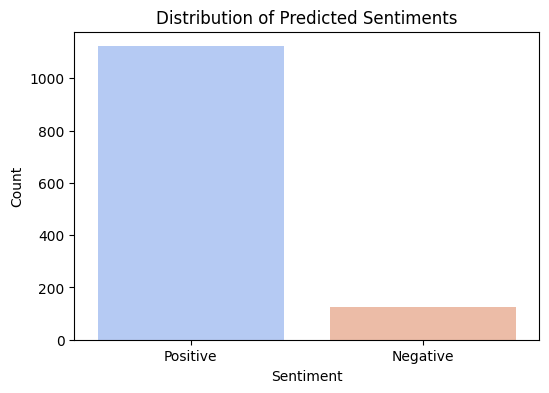

In [94]:
# Count occurrences of each sentiment
sentiment_df = pd.DataFrame({"Sentiment": sentiment_output})
sentiment_counts = sentiment_df["Sentiment"].value_counts()

# Plot bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Predicted Sentiments")
plt.show()

In [96]:
print(len(article), len(sentiment_output), len(sent_perc))


1248 1248 1248


In [97]:
df_results = pd.DataFrame({"Article": article, "Predicted Sentiment": sentiment_output, "Sentiment Score": sent_perc})

# Top 5 positive articles
top_positive = df_results[df_results["Predicted Sentiment"] == "Positive"].nlargest(5, "Sentiment Score")
print("Top Positive Sentiments:\n", top_positive)

# Top 5 negative articles
top_negative = df_results[df_results["Predicted Sentiment"] == "Negative"].nlargest(5, "Sentiment Score")
print("Top Negative Sentiments:\n", top_negative)

Top Positive Sentiments:
                                                Article Predicted Sentiment  \
5    Montpelier Re Holdings Ltd. (MRH): New Analyst...            Positive   
609                    Вышел Netscape Communicator 4.7            Positive   
162             ФБР поможет России прикрыть kavkaz.org            Positive   
469                               Погода: прогноз-2000            Positive   
829  Gartner Group: продукты Microsoft для корпорац...            Positive   

     Sentiment Score  
5           0.934417  
609         0.932724  
162         0.931358  
469         0.921566  
829         0.919042  
Top Negative Sentiments:
                                                Article Predicted Sentiment  \
108  Блок "Отечество — Вся Россия" представил в ЦИК...            Negative   
16        Литва засудила участников переворота 91 года            Negative   
601  ЦРУ вкладывает деньги Конгресса в высокие техн...            Negative   
212        Чуть не сгорел цен